## Utilizando bagging ensemble com CNNs 🧩

**Resumo:**
As redes neurais convolucionais são um tipo de arquitetura muito popular em deep learning. A partir da operação matemática de convolução foi possível construir redes que conseguem aprender padrões complexos de dados utilizando uma menor quantidade de processamento computacional e obtém resultados satisfatórios principalmente em problemas de visão computacional. 

O ensemble, por outro, lado é uma técnica utilizada para melhorar o resultado de modelos de machine learning. Em geral, se reune vários modelos e no final se agrega as predições. Diversos algoritmos realizam essa tarefa de diferentes formas, o que vamos estudar nesse notebook é o bagging ensemble. 

#### TABLE OF CONTENTS
* [Biblotecas e dados](#bibliotecas)
* [Criando e treinando o modelo](#train_model)
* [Avaliando o modelo](#avaliacao)
* [Gerando saída](#saida)
* [Criando um bagging ensemble](#bagging)
* [Avaliando o ensemble](#avalicao_en)
* [Gerando saída do ensemble](#saida_en)

<h1>Bibliotecas e Dados 
 <a id="bibliotecas" class="anchor-link" href="#bibliotecas">¶</a>
</h1>

In [1]:
# Bibliotecas necessárias
# Manipulação de dados
import pandas as pd
import numpy as np
# Redes Neurais
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
#camadas de preprocessamento
from keras import layers
from tensorflow.keras.layers import Dense, Dropout, \
Conv2D, MaxPooling2D,GlobalMaxPooling2D,BatchNormalization,InputLayer
from tensorflow.keras.optimizers import Adam
# Plot
import matplotlib.pyplot as plt
%matplotlib inline
# Avaliação
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
#ensemble
from sklearn.utils import resample


Using TensorFlow backend.


In [2]:
# Lendo o dataset Kaggle
train_full = pd.read_csv("../input/digit-recognizer/train.csv")
test = pd.read_csv("../input/digit-recognizer/test.csv")



In [3]:
# Analisando o dataset
print("Quantidade de elementos de treino: {}". format(len(train_full)))
print(train_full.head())

Quantidade de elementos de treino: 42000
   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  

In [4]:
#visualizando o shape dos arquivos de treino e teste
print("shape de train:",train_full.shape)
print("shape de test:",test.shape)

shape de train: (42000, 785)
shape de test: (28000, 784)


In [5]:
# Separando x_train, x_valid,x_test e y_train,y_valid,y_test e fazendo preprocessamento
#vamos utilizar 37001 imagens para train,5000 para validação e 28000 para 
x_train,x_valid,x_test = train_full.loc[:len(train_full)-5000,"pixel0":]/255.,train_full.loc[len(train_full)-5000:,"pixel0":]/255.,test/255.
y_train,y_valid = train_full.loc[:len(train_full)-5000,"label"],train_full.loc[len(train_full)-5000:,"label"]

In [6]:
#visualizando shape dos dados
print("Shape de x_train e y_train:",(x_train.shape,y_train.shape))
print("Shape de x_valid e y_valid:",(x_valid.shape,y_valid.shape))
print("Shape de x_test:",x_test.shape)

Shape de x_train e y_train: ((37001, 784), (37001,))
Shape de x_valid e y_valid: ((5000, 784), (5000,))
Shape de x_test: (28000, 784)


In [7]:
#transformando os vetores em imagens de 28 x 28 x 1
x_train = np.reshape(x_train.values,(x_train.shape[0],28,28,1))
x_valid = np.reshape(x_valid.values,(x_valid.shape[0],28,28,1))
x_test = np.reshape(x_test.values,(x_test.shape[0],28,28,1))

print("Shape de x_train e y_train:",(x_train.shape,y_train.shape))
print("Shape de x_valid e y_valid:",(x_valid.shape,y_valid.shape))
print("Shape de x_test:",x_test.shape)


Shape de x_train e y_train: ((37001, 28, 28, 1), (37001,))
Shape de x_valid e y_valid: ((5000, 28, 28, 1), (5000,))
Shape de x_test: (28000, 28, 28, 1)


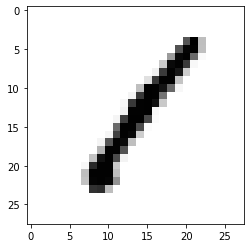

In [8]:
#visualizando uma imagem 
plt.imshow(x_train[0][:,:,0],cmap="Greys");

In [9]:
# Vamos ajustar o formato da saida
num_classes = 10

# Convertendo para um vetor de saida com 10 dimensoes
# ex. 8 => [0,0,0,0,0,0,0,0,1,0]
y_train,y_valid = keras.utils.to_categorical(y_train, num_classes),keras.utils.to_categorical(y_valid, num_classes)
print("visualizando o formato de y_train:",y_train[0])
print("visualizando o formato de y_valid:",y_valid[0])

visualizando o formato de y_train: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
visualizando o formato de y_valid: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


<h1>Criando e treinando o modelo
 <a id="train_model" class="anchor-link" href="#train_model">¶</a>
</h1>

A arquitetura de uma CNN contém duas partes importantes:
 * Base: Convolutional layers 
 * Head: Fully conected layer
 
Em resumo, na base, as convolutional layers vão identificar diversos paramêtros (features) da camada de entrada e no head esses paramêtros são analisados e combinados para encontrar quais deles são relevantes para resolver o problema em questão. 

Aprofundando mais esses conceitos, na base, são reunidos os features maps, eles são resultado das operações de convolução (filtragem da imagem) e função de ativação, ou seja, aqui são destacados diversos aspectos das imagens. É valido destacar que nas primeiras camadas esses padrões são simples (bordas, cores, formas e etc), já para as últimas, temos padrões mais complexos (texturas, padrões de olhos e narizes)

A partir disso, a camada de head (ou top) reúne essas informações e procura classificar as imagens encontradas. Aqui, a finalidade é saber quais dos diversos features maps são relevantes para a classificação. Nessa camada, geralmente, pode-se ter uma dense network ou uma global poolying layer

<div class="alert alert-block alert-info" style="color:black; font-size:14px;">
    📌 A camada de output deve ter o mesmo tamanho da quantidade dos dados a serem classificados.
    <br>
    📌 Em geral, nas convolutional layers, a quantidade de filtros é aplicada em ordem crescente (64,128,256..) e são seguidas de pooling layers com strides de 2. Dessa forma, pouca memoria RAM é consumida (as pooling layers reduzem a dimensão da imagem e condensam as informações das covolutional layers) e mais reuniões de features são feitas nas camadas mais superiores (ou seja, mais parametros complexos são formados). Contudo, isso não é uma regra, é válido fazer vários testes com diferentes quantidade de filtros para saber qual é o melhor para seus dados. 
    </div>

**Data Augmentation 
**

O data augumentation se resume em produzir artificialmente novas imagens de diferentes formatos em relação a original sem fazer com que ela perca seu significado de classificação. É uma técnica de preprocessamento para fazer com que a rede aprenda também outras formas de visualizar a camada de entrada e saber lidar com situações diferentes. Algumas transformações feitas são: rotação da imagem, aplicação de zoom, alteração de largura e altura, aumentar/diminuir constraste e entre outras tecnicas.

In [10]:
#camadas de data augumentation

dataGen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    zoom_range = 0.20,
    width_shift_range=0.1,
    height_shift_range=0.1,
)

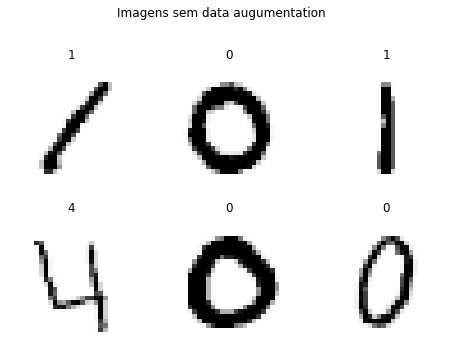

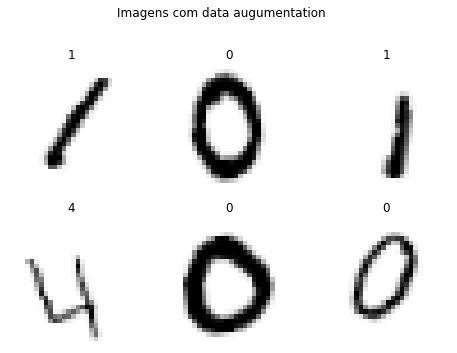

In [11]:
#visualizando data augmentation

#primeiro verificando imagens originais 
ex_imgs = x_train[0:6,:,:,:]
label_ex_imgs = y_train[0:6]

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.suptitle("Imagens sem data augumentation")
for i in range(6):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(ex_imgs[i][:,:,0],cmap="Greys")
    plt.title(np.argmax(label_ex_imgs[i]))
    plt.axis("off")

plt.figure(figsize=(8,8))
plt.subplot(1,2,2)
plt.suptitle("Imagens com data augumentation")
for i in range(6):
    ax = plt.subplot(3,3,i+1)
    new_img = dataGen.random_transform(ex_imgs[i])
    plt.imshow(new_img[:,:,0],cmap="Greys")
    plt.title(np.argmax(label_ex_imgs[i]))
    plt.axis("off")

In [12]:
# Criando o modelo Sequential
# Sequential: Modelo Keras de ir adicionando camadas (como um lego)

# Conv2D: Camada com kernels (filtros) que percorrem a imagem extraindo caracterísitcas (mapas de caracteísticas)

# MaxPooling2D: Camada que reduz a dimensionalidade dos mapas de características 2D -->
# Ela divide a imagem em pequenos blocos e encontra neles o pixel de maior valor. 

# Dropout: Camada usa durante treino que descarta aleatoriamente um percentual de conexões (reduz overfitting)

# GlobalMaxPooling2D: Reduz os features maps para um único número. 
# Enfatiza a presença ao modelo a presença de um feature.
# Seu output para a GlobalMaxPooling2D é o valor máximo de ativação do feature map analisado. 


model = Sequential()
model.add(InputLayer(input_shape=(28,28,1)))
#primeira camada de conv
model.add(Conv2D(32,kernel_size=5,activation="relu",padding="same"))
model.add(MaxPooling2D()),
model.add(Dropout(0.15))
model.add(BatchNormalization())

#segunda camada de conv
model.add(Conv2D(64,kernel_size=3,activation="relu",padding="same"))
model.add(MaxPooling2D(pool_size=(1,1))),
model.add(Dropout(0.15))
model.add(BatchNormalization())

#terceira camada de conv
model.add(Conv2D(64,kernel_size=3,activation="relu",padding="same"))
model.add(Conv2D(64,kernel_size=3,activation="relu",padding="same"))
model.add(MaxPooling2D(pool_size=(1,1)))
model.add(Dropout(0.25))

#camada de classficação
model.add(BatchNormalization())
model.add(GlobalMaxPooling2D())
model.add(Dropout(0.15))
model.add(Dense(10,activation="softmax"))

In [13]:
#visualizando o modelo
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0

In [14]:
# Compila o modelo
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.01,epsilon=0.01),
              metrics=['accuracy'])

In [15]:
# Treina com os parte dos dados
batch_size = 32
epochs = 30

#Salvar o melhor modelo
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='model.h5',
        monitor='val_loss', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001)
    
]

history = model.fit(dataGen.flow(x_train, y_train,batch_size=batch_size,seed=42),
                   validation_data=(x_valid, y_valid),
                   epochs=epochs,
                   callbacks=callbacks_list)

Train for 1157 steps, validate on 5000 samples
Epoch 1/30
1154/1157 [============================>.] - ETA: 0s - loss: 0.5584 - accuracy: 0.8373
Epoch 00001: val_loss improved from inf to 0.15170, saving model to model.h5
1157/1157 [==============================] - 21s 18ms/step - loss: 0.5575 - accuracy: 0.8376 - val_loss: 0.1517 - val_accuracy: 0.9522
Epoch 2/30
1156/1157 [============================>.] - ETA: 0s - loss: 0.1316 - accuracy: 0.9601
Epoch 00002: val_loss improved from 0.15170 to 0.05422, saving model to model.h5
1157/1157 [==============================] - 19s 16ms/step - loss: 0.1315 - accuracy: 0.9601 - val_loss: 0.0542 - val_accuracy: 0.9854
Epoch 3/30
1155/1157 [============================>.] - ETA: 0s - loss: 0.0921 - accuracy: 0.9723
Epoch 00003: val_loss improved from 0.05422 to 0.05198, saving model to model.h5
1157/1157 [==============================] - 17s 15ms/step - loss: 0.0922 - accuracy: 0.9722 - val_loss: 0.0520 - val_accuracy: 0.9842
Epoch 4/30
1156

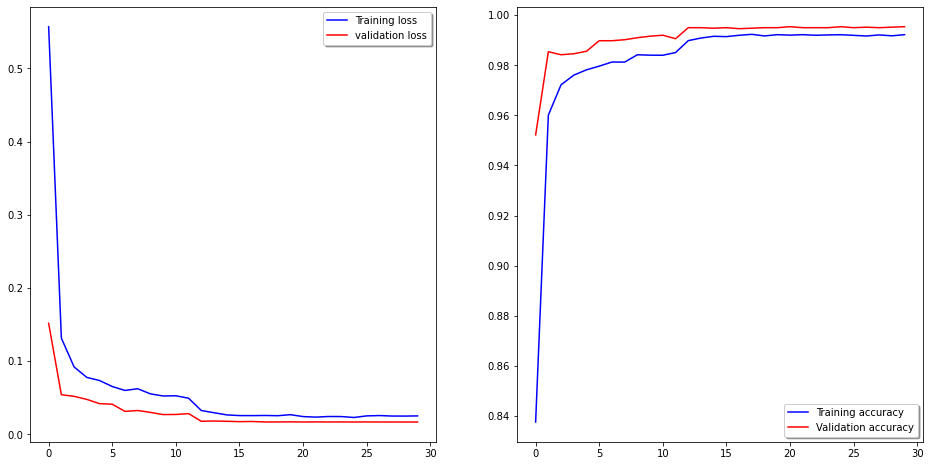

In [16]:
#Vamos ver como foi o treino?

fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [17]:
from tensorflow.keras.models import load_model
# Load the best saved model
model = load_model('model.h5')

In [18]:
# Testa
score = model.evaluate(x_valid, y_valid, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Validation loss: 0.0168805504869204
Validation accuracy: 0.9952


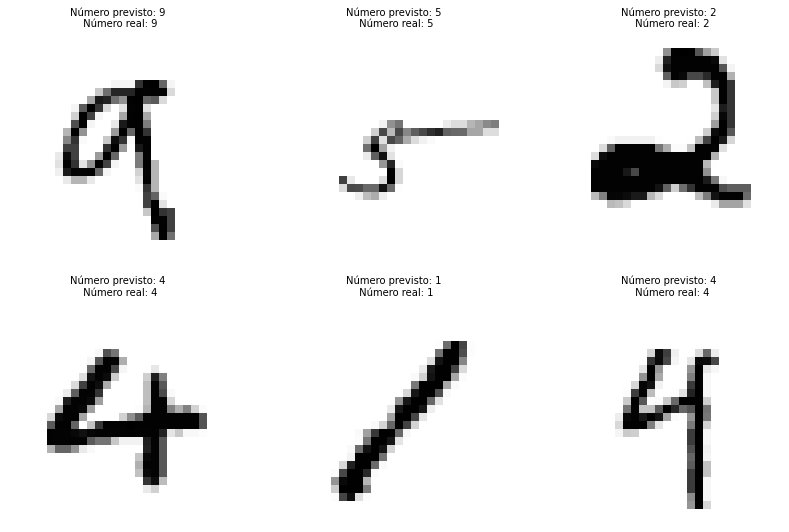

In [19]:
#Visualizando as predições no subset de validação
plt.figure(figsize=(14,14)) 
pred_images = model.predict(x_valid[0:6,:,:,:])
for i in range(6): #show 6 images 
    ax = plt.subplot(3,3,i+1)
    plt.imshow(x_valid[i,:,:,0],cmap="Greys")
    y_pred_valid = pred_images[i]
    plt.title(f"Número previsto: {np.argmax(y_pred_valid)} \n Número real: {np.argmax(y_valid[i])}",
             fontsize=10)
    plt.axis("off")

<h1> Avaliando o modelo 
<a id="avaliacao" href="#avaliacao" class="anchor-link">¶</a>    
</h1>

In [20]:
import itertools

#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       520
           1       1.00      1.00      1.00       563
           2       1.00      0.99      1.00       465
           3       0.99      1.00      1.00       530
           4       1.00      0.99      0.99       521
           5       1.00      0.99      0.99       415
           6       1.00      1.00      1.00       494
           7       1.00      1.00      1.00       506
           8       0.99      0.99      0.99       485
           9       0.99      0.99      0.99       501

    accuracy                           1.00      5000
   macro avg       1.00      1.00      1.00      5000
weighted avg       1.00      1.00      1.00      5000



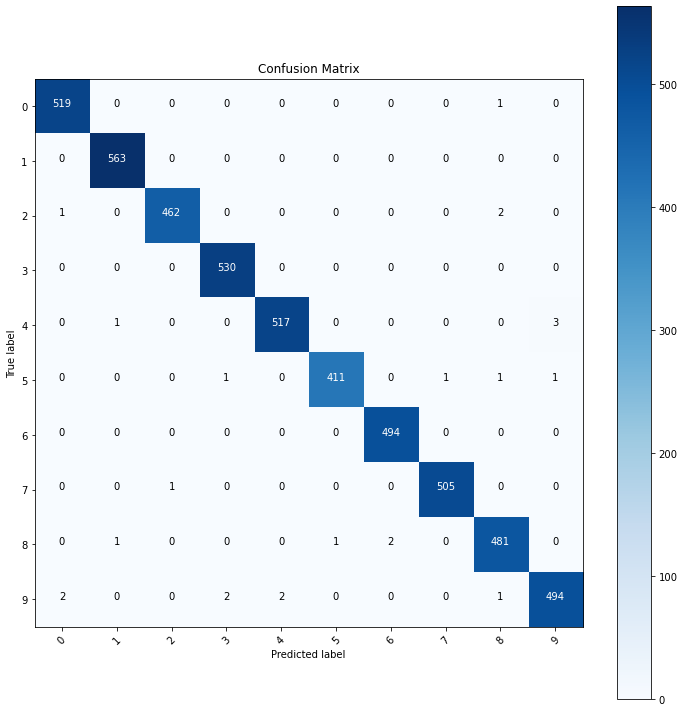

In [21]:
# Vendo alguns reports# Vendo alguns reports
# Usando sklearn
import numpy as np

# Classificando toda base de teste
y_pred = model.predict_classes(x_valid)
# voltando pro formato de classes
y_test_c = np.argmax(y_valid, axis=1)
target_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

#Confution Matrix
cm = confusion_matrix(y_test_c, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

print('Classification Report')
print(classification_report(y_test_c, y_pred, target_names=target_names))

<h1>Gerando saída
 <a id="saida" class="anchor-link" href="#saida">¶</a>
</h1>

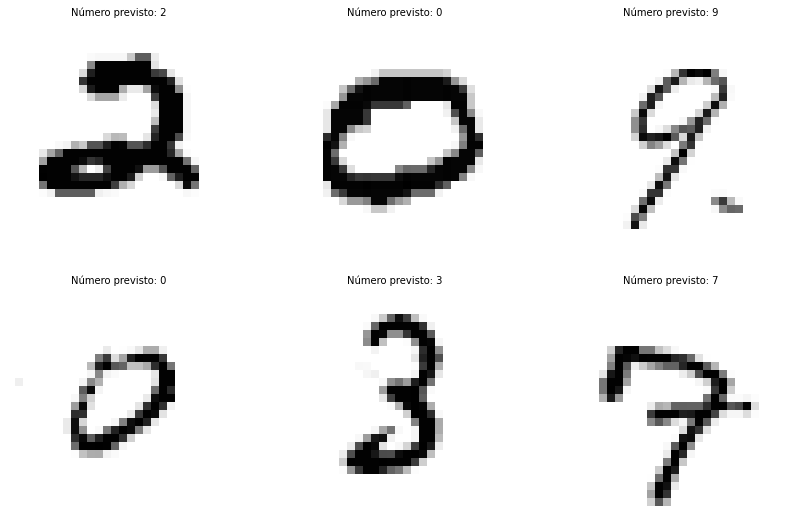

In [22]:
# Gerando saída para dataset de teste

# Faz classificação para dataset de teste
y_pred_test = model.predict_classes(x_test)

# Visualizando exemplos
plt.figure(figsize=(14,14))
for i in range(6): #show 6 images 
    ax = plt.subplot(3,3,i+1)
    plt.imshow(x_test[i,:,:,0],cmap="Greys")
    plt.title(f"Número previsto: {y_pred_test[i]}",
             fontsize=10)
    plt.axis("off")

<h1>Criando um bagging ensemble
    <a id="bagging" class="anchor-link" href="bagging">¶</a>
</h1>

Um bagging ensemble procura treinar um único modelo com diferentes dados do datasets e ao final as predições são feitas com base em quem teve uma maior frequência entre os modelos para o caso de classificação ou a média dos resultados para problemas de regressão.

<div style=" display: block; margin-left: auto; margin-right: auto; width: 50%;">
<img src="https://images.ctfassets.net/8qlu80sl3ynp/6B8g45iTyrQusAbnPNCU0O/413773241fda93830de7b6c6922d06aa/knowledge_ensemble_bagging.png" alt="bagging"/>
</div>



Ao criar diferentes subsets de treino podemos ter dados com repetição, ou seja, quem apareceu no primeiro subset de treino pode aparecer nos outros (isso é conhecido como o bagging) mas é possível não repetir os dados,então, os modelos veem apenas partes do conjunto total de treinamento (isso é conhecido como pasting). 

Em geral, os modelos criados pelo bagging ensemble tem um bias maior do que um único modelo criado com os dados de treinamento, contudo, a agregação dos resultados reduz tanto o bias quanto a variância, logo, obtemos um modelo com bias similar ao de um único modelo criado com os dados de treinamento porém com uma variância menor em relação ao mesmo.



Os passos para criar o bagging ensemble são os seguintes:

<ol style="list-style-type:upper-roman">
    <li>vamos criar uma função fit_model para criar um único modelo base para o ensemble.</li>
    <li> Em seguida, a função ensemble_models cria N modelos (definidos por n_estimators) com uma quantidade máxima de M dados (definido por max_samples). Para garantir o bagging, a função resample da scikit learn realiza um shuffle dos indexes dos dados de treinamento recebidos e para cada iteração seleciona partes dos mesmos (podendo ou não ter repetição). </li>
    <li>Ao final, as predições dos modelos são feitas pela função ensemble_predicitons, nela as predições dos modelos são somadas e o resultado final é definido por aquela classe que teve maior % probabilidade nesse agregação. </li>
</ol>

In [23]:
## Criando bagging emsemble 

#função para criar um único modelo 
def fit_model(X_train,y_train,X_valid,y_valid,with_aug=True):
    #definindo callbacks
    callbacks_list = [
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,verbose=1,restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001)
    
]
    optimizer = Adam(epsilon=0.01,learning_rate=0.01)
    
    ####definindo modelo base 
    model = Sequential()
    model.add(InputLayer(input_shape=(28,28,1)))
    #primeira camada de conv
    model.add(Conv2D(32,kernel_size=5,activation="relu",padding="same"))
    model.add(MaxPooling2D()),
    model.add(Dropout(0.15))
    model.add(BatchNormalization())

    #segunda camada de conv
    model.add(Conv2D(64,kernel_size=3,activation="relu",padding="same"))
    model.add(MaxPooling2D(pool_size=(1,1))),
    model.add(Dropout(0.15))
    model.add(BatchNormalization())

    #terceira camada de conv
    model.add(Conv2D(64,kernel_size=3,activation="relu",padding="same"))
    model.add(Conv2D(64,kernel_size=3,activation="relu",padding="same"))
    model.add(MaxPooling2D(pool_size=(1,1)))
    model.add(Dropout(0.25))

    #camada de classficação
    model.add(BatchNormalization())
    model.add(GlobalMaxPooling2D())
    model.add(Dropout(0.15))
    model.add(Dense(10,activation="softmax"))
    
    if with_aug:
        dataGen = tf.keras.preprocessing.image.ImageDataGenerator(
            rotation_range=10,
            zoom_range = 0.20,
            width_shift_range=0.1,
            height_shift_range=0.1
        )
        model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        model.fit(dataGen.flow(X_train,y_train),validation_data=(X_valid,y_valid),epochs=30,verbose=0)
        val_loss,val_acc = model.evaluate(X_valid,y_valid,verbose=0)
    else:
        model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        model.fit(X_train,y_train,validation_data=(X_valid,y_valid),epochs=30,verbose=0)
        val_loss,val_acc = model.evaluate(X_valid,y_valid,verbose=0)
        
    return model,val_loss,val_acc

In [24]:
#criando ensemble de modelos 
def ensemble_models(X_train,y_train,n_estimators=5,max_samples=100):
    models = []
    val_losses = []
    scores = []
    for i in range(n_estimators):
        #select indexes
        ix = [ix for ix in range(len(X_train))]
        #resample faz um "shuffle" dos indexes das matrizes
        #bagging precisa do replace = True
        train_ix = resample(ix,replace=True,n_samples=max_samples)
        valid_ix = [x for x in ix if x not in train_ix]
        #select data
        X_train_en,X_valid_en = X_train[train_ix],X_train[valid_ix]
        y_train_en,y_valid_en = y_train[train_ix],y_train[valid_ix]
        #evaluate models
        model,val_loss,val_acc = fit_model(X_train_en,y_train_en,X_valid_en,y_valid_en)
        models.append(model)
        val_losses.append(val_loss)
        scores.append(val_acc)
        
    return models,val_losses,scores

In [25]:
#realizando predições 
def ensemble_predictions(models,X_valid):
    ##armazena predições em array
    all_preds = [model.predict(X_valid) for model in models]
    #transforma a lista em numpy array
    all_preds = np.array(all_preds)
    #faz a soma de todas as probabilidades das predições dos modelos
    summed = np.sum(all_preds,axis=0)
    #argmax across classes
    result = np.argmax(summed, axis=1)
    return result

Para facilitar a validação dos modelos, a função evaluate_n_members reune os modelos e aplica a função de validação nos dados de teste. 

A quantidade de modelos utilizados pelo ensemble é definida por n_members.

In [26]:
#avaliando os modelos 
def evaluate_n_members(members, n_members, X_valid, y_valid):
	# select a subset of members
	subset = members[:n_members]
	# make prediction
	y_pred = ensemble_predictions(subset, X_valid)
	# calculate accuracy
	return accuracy_score(y_valid, y_pred)

In [27]:
qtde_modelos = 5
models,val_losses,scores = ensemble_models(x_train,y_train,n_estimators=qtde_modelos,max_samples=20000)

In [28]:
print(f"Acurácia média de todos os modelos: {np.mean(scores):.4f}")
print(f"Validation loss média de todos os modelos:{np.mean(val_losses):.4f}")

Acurácia média de todos os modelos: 0.9918
Validation loss média de todos os modelos:0.0288


In [29]:
#avaliando o ensemble e os modelos únicos 
for i in range(1,qtde_modelos+1):
    ensemble_score = evaluate_n_members(models,i,x_valid,np.argmax(y_valid,axis=1))
    _,single_score = models[i-1].evaluate(x_valid,y_valid,verbose=0)
    print(f"single score accuracy: {single_score:.4f}, ensemble score accuracy: {ensemble_score:.4f}")
    

single score accuracy: 0.9906, ensemble score accuracy: 0.9906
single score accuracy: 0.9944, ensemble score accuracy: 0.9942
single score accuracy: 0.9918, ensemble score accuracy: 0.9950
single score accuracy: 0.9926, ensemble score accuracy: 0.9946
single score accuracy: 0.9914, ensemble score accuracy: 0.9948


In [30]:
#verificando nos dados do teste 
val_acc = evaluate_n_members(models,qtde_modelos,x_valid,np.argmax(y_valid,axis=1))
print(f"Acurácia final do ensemble: {val_acc:.4f}")

Acurácia final do ensemble: 0.9948


In [31]:
#salvando modelos 
import os
##criando diretorio no /kaggle/working --diretorio atual
os.mkdir("./ensemble_models")
for i in range(len(models)):
    model = models[i]
    model.save(f"./ensemble_models/model_{i+1}.h5")
    

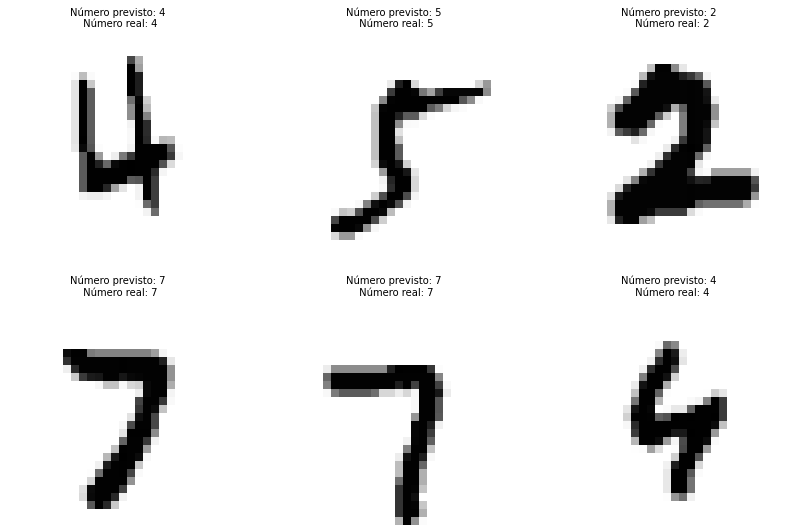

In [32]:
#Visualizando as predições no subset de validação
plt.figure(figsize=(14,14)) 
pred_images_en_valid = ensemble_predictions(models,x_valid[6:12,:,:,:])
for i in range(6): #show 6 images 
    ax = plt.subplot(3,3,i+1)
    #de 6 em diante
    plt.imshow(x_valid[6+i,:,:,0],cmap="Greys")
    plt.title(f"Número previsto: {pred_images_en_valid[i]} \n Número real: {np.argmax(y_valid[6+i])}",
             fontsize=10)
    plt.axis("off")

<h1>Avalaindo o ensemble
 <a id="avalicao_en" class="anchor-link" href="#avaliacao_en">¶</a>
</h1>

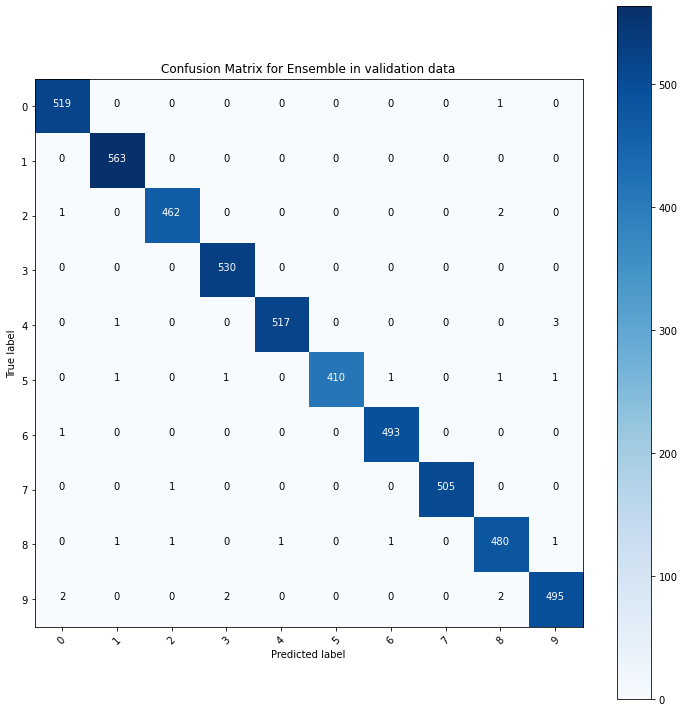

In [33]:
#vamos avaliar pela matriz de confusão 

y_pred_en = ensemble_predictions(models,x_valid)

#Confution Matrix
cm_en = confusion_matrix(np.argmax(y_valid,axis=1), y_pred_en)
plot_confusion_matrix(cm_en, target_names, normalize=False, title='Confusion Matrix for Ensemble in validation data')

In [34]:
#mostrando o report 
print('Classification Report for Ensemble in validation data')
print(classification_report(np.argmax(y_valid,axis=1), y_pred, target_names=target_names))

Classification Report for Ensemble in validation data
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       520
           1       1.00      1.00      1.00       563
           2       1.00      0.99      1.00       465
           3       0.99      1.00      1.00       530
           4       1.00      0.99      0.99       521
           5       1.00      0.99      0.99       415
           6       1.00      1.00      1.00       494
           7       1.00      1.00      1.00       506
           8       0.99      0.99      0.99       485
           9       0.99      0.99      0.99       501

    accuracy                           1.00      5000
   macro avg       1.00      1.00      1.00      5000
weighted avg       1.00      1.00      1.00      5000



<h1>Gerando a saída do ensemble <a id="saida_en" class= "anchor-link"href="#saida_en">¶</a><h1>
 

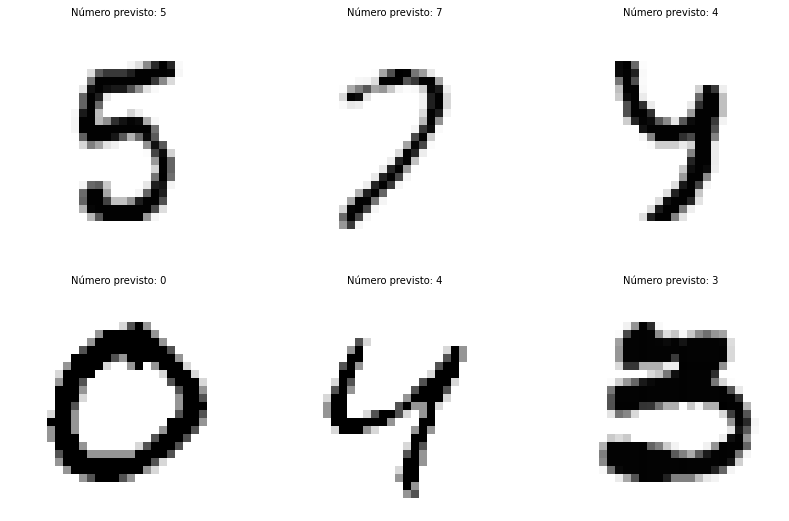

In [35]:
#realizando predições nos dados de teste

# Faz classificação para dataset de teste
y_pred_test_en = ensemble_predictions(models,x_test)

# Visualizando exemplos
plt.figure(figsize=(14,14))
for i in range(6): #show 6 images 
    ax = plt.subplot(3,3,i+1)
    #pegando a partir de 10 em diante
    plt.imshow(x_test[10+i,:,:,0],cmap="Greys")
    plt.title(f"Número previsto: {y_pred_test_en[10+i]}",
             fontsize=10)
    plt.axis("off")

In [36]:
##armazenando dados para submissão 

results = pd.Series(y_pred_test_en,name="Label")
submission = pd.concat([pd.Series(range(1,len(y_pred_test_en)+1),name = "ImageId"),results],axis = 1)
print(submission.head(10))
#Salvando Arquivo
submission.to_csv("submission.csv",index=False)

   ImageId  Label
0        1      2
1        2      0
2        3      9
3        4      0
4        5      3
5        6      7
6        7      0
7        8      3
8        9      0
9       10      3


*Referencias*
* Figueireido, Mauricio. CNN simples com Keras para Iniciantes. Disponível em: https://www.kaggle.com/mauriciofigueiredo/cnn-simples-com-keras-para-iniciantes. Acesso em: 07/03/2022.

* Brownlee, Jason. How to Create a Bagging Ensemble of Deep Learning Models in Keras. Disponível em: 
 https://machinelearningmastery.com/how-to-create-a-random-split-cross-validation-and-bagging-ensemble-for-deep-learning-in-keras/. Acesso em: 10/03/2022

* Gérion, Aurélien. Hands-on machine learning with scikit-learn,keras and tensorflow. 2ed. Canadá: O'Reilly Media. 2019